In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 8.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import h5py
import timm
import matplotlib.pyplot as plt
import seaborn
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
di = '/kaggle/input/g2net-detecting-continuous-gravitational-waves'

%matplotlib inline

In [4]:
train_labels = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
submission = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')

In [5]:
#Removing the negative labels
train_labels = train_labels[train_labels.target>=0]
train_labels.target.value_counts()

1    400
0    200
Name: target, dtype: int64

In [6]:
#defining a configuration
class CFG:
    model_name = 'tf_efficientnet_b4_ns'
    target_size = 1
    nfold = 5
    batch_size = 16
    epochs = 16
    num_workers = 2
    lr = 1e-3
    weight_decay = 1e-6
    train = True
    seed = 42
    score_method = 'roc_auc_score'
    scheduler_type = 'CosineLRScheduler'
    optimizer_type = 'Adam'
    loss_type = 'BCEWithLogitsLoss'
    max_grad_norm = 1000
    lr_max = 4e-4
    epochs_warmup = 1.0

In [7]:
def get_criterion():
    if CFG.loss_type == 'CrossEntropyLoss':
        return nn.CrossEntropyLoss()
    if CFG.loss_type == 'BCEWithLogitsLoss':
        return nn.BCEWithLogitsLoss()

In [8]:
def get_optimizer(model):
    if CFG.optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    if CFG.optimizer_type == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay)
    return optimizer

In [9]:
def get_scheduler(optimizer, warmup, nsteps):
    if CFG.scheduler_type == 'StepLR':
        scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
    if CFG.scheduler_type == 'CosineLRScheduler':
        scheduler = CosineLRScheduler(optimizer,
                                      warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,
                                      t_initial=(nsteps - warmup), lr_min=1e-6) 
    return scheduler

In [10]:
def get_score(y_true, y_pred):
    if CFG.score_method == "roc_auc_score":
        score = roc_auc_score(y_true, y_pred)
    if CFG.score_method == "accuracy_score":
        score = accuracy_score(y_true, y_pred)
    return score

In [11]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df):
        self.data_type = data_type
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64

                p = a.real**2 + a.imag**2  # power
                p /= np.mean(p)  # normalize
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128

                img[ch] = p

        return img, y

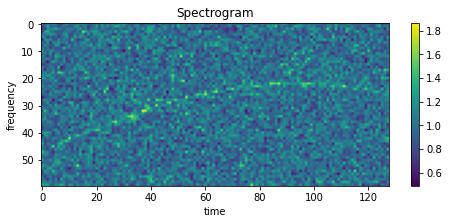

In [12]:
dataset = Dataset('train', train_labels)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 300:360]) # zooming in for dataset[10]
plt.colorbar()
plt.show()

In [13]:
len(dataset)

600

In [14]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=2)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.fc = nn.Linear(n_features, 1)
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [15]:
def valid_fn(valid_loader, model, criterion, device, compute_score=True):
    
    tb = time.time() 
    model.eval() # switch to evaluation mode
    preds = []
    y_all = []
    running_loss = 0
    count = 0
    
    pbar = tqdm(valid_loader, total=len(valid_loader))
    pbar.set_description("Validation")
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        running_loss += loss.item()*labels.shape[0]
        count += 1
        # record accuracy
        y_all.append(labels.cpu().detach().numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    
    del loss, images, labels, y_preds
    
    y_ground = np.concatenate(y_all)
    y_pred = np.concatenate(preds)
    score = get_score(y_ground, y_pred) if compute_score else None 
    val_loss = running_loss/count
    
    val_dict = {'loss': val_loss,
               'score': score,
               'y': y,
               'y_pred': y_pred,
                'time': (time.time() - tb)/60
               }
    
    return val_dict

In [16]:
model = Model(CFG.model_name, pretrained=False)
filename = '/kaggle/input/g2net-train/model3.pytorch'
model.to(device)
model.load_state_dict(torch.load(filename, map_location=device))
model.eval()
criterion = get_criterion()

# Predict
submit = pd.read_csv(di + '/sample_submission.csv')
dataset_test = Dataset('test', submit)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                          num_workers=CFG.num_workers, pin_memory=True)

test = valid_fn(loader_test, model, criterion, device, compute_score=False)

# Write prediction
submit['target'] = test['y_pred']
submit.to_csv('submission.csv', index=False)

  0%|          | 0/125 [00:00<?, ?it/s]

In [17]:
submit.head()

,id,target
0,00054c878,0.448144
1,0007285a3,0.690240
2,00076c5a6,0.446068
3,001349290,0.521155
4,001a52e92,0.382816
